# Numerical simulation of radial multiple SLE

This code uses the work of https://github.com/hfcredidio/loew and https://github.com/andrea-dm/schramm-loewner-evolution. The numerical simulation is based on Kennedy, T., "Numerical Computations for the Schramm-Loewner Evolution", J Stat Phys (2009) 137: 839. doi:10.1007/s10955-009-9866-2.



First, load some packages and functions:

In [0]:
!pip install sdeint
import numpy                as np
import numexpr              as ne
import sdeint    # for solving stochastic differential equations numerically           
import matplotlib.pylab as plt
import imageio
from IPython.display import Image, display

def radial_vslit_zip(z, dt, u):
    '''
    Vertical slit discretication of radial Loewner chains. This function is
    the inverse of the solution of Loewner's Equation with driving function
    U(t) = u, for 0 <= t <= dt
    Parameters
    ----------
    z : complex or ndarray of complexes
        Input array.
    dt: float
    u: complex
        Vertical slit parameters.
    Returns
    -------
    w : complex or ndarray of complxes
        Same shape as input array.
    '''
    z = z / u 
    w =  ne.evaluate("(exp(dt) - 2* z + 2* exp(dt)* z + exp(dt)* z**2 - exp(dt/2)* (1 + z)* sqrt(-4*z + exp(dt)* (1 + z)**2))/(2* z)")
    return w * u

def radial_multiple_slits(t, lambdas, u) :
    '''
    ----------
    Parameters
    ----------
    t:              1d ndarray of floats
                            Time instants where the driving is sampled.
    lambdas: array containing the nslits many coefficients >=0
    u:   n 1d ndarrays of complex
                            Sampled values of the driving functions.

    ----------
    Returns
    -------
    z: list of n 1d ndarray of complex
        Points of the trace at each time instant.

    ----------
    '''
    nsteps = len(t)

    nslits = u.shape[0]
        
    #initializing the trace array...
    z = np.empty([nslits,nsteps], dtype=np.complex)
  #  for slit in range(0,nslits) :
  #      z[slit][:nsteps] += (u[slit][:nsteps]+0.000001j)
        
    for m in range(0, nslits, 1):
        for j in range(0, nsteps, 1):
            z[m][j] =  0.999999 * u[m][j]

    #getting the trace...
    for step in range(nsteps-1, 0, -1):
        dt = (t[step] - t[step-1])            
        for slit1 in range(0, nslits, 1): 
            for slit2 in range(0, nslits, 1): 
                z[slit2][step:] = radial_vslit_zip(z[slit2][step:], dt*lambdas[slit1], u[slit1][step])

    return z

def radial_multiple_sle_driving_functions(kappa, Nslits, x0, tspan, lambdas):
    '''
    ----------
    Parameters
    ----------
    kappa:  the 'kappa' of SLE(kappa)
    Nslits: number of multiple sle slits
    x0: array of the initial points of the slits on the unit circle
    tspan: time points
    lambdas: array containing the nslits many coefficients >=0
    ----------
    Returns
    -------
    result: array of dimension len(tspan)*Nslits of real
            numbers, representing the Nslits driving functions

    ----------
    '''

    def f(x, t):
        res = np.zeros(Nslits, dtype=np.complex_)
        for k in range(0, Nslits, 1):
            for m in range(0, Nslits, 1):
                if k != m:
                    res[k] = res[k] + (lambdas[k]+lambdas[m])*(x[m]+x[k])/(x[m]-x[k])
            res[k] = res[k] - kappa * lambdas[k]/2
            res[k] = res[k] * x[k]

        return np.array(res)

    def G(x, t):
        res = np.zeros(Nslits, dtype=np.complex_)
        for k in range(0, Nslits, 1):
            res[k] = 1j * x[k] * np.sqrt(kappa * lambdas[k])
        return np.diag(res)

    result = sdeint.itoint(f, G, x0, tspan)
    result = np.transpose(result)
    
    return result

    
# Two time spans such that the first time steps can have a more dense spacing.
def radial_multiple_sle_driving_functions2(kappa, Nslits, x0, tspan1, tspan2, lambdas):
    '''
    ----------
    Parameters
    ----------
    kappa:  the 'kappa' of SLE(kappa)
    Nslits: number of multiple sle slits
    x0: array of the initial points of the slits on the unit circle
    tspan: time points
    lambdas: array containing the nslits many coefficients >=0
    ----------
    Returns
    -------
    result: array of dimension len(tspan)*Nslits of real
            numbers, representing the Nslits driving functions

    ----------
    '''

    def f(x, t):
        res = np.zeros(Nslits, dtype=np.complex_)
        for k in range(0, Nslits, 1):
            for m in range(0, Nslits, 1):
                if k != m:
                    res[k] = res[k] + (lambdas[k]+lambdas[m])*(x[m]+x[k])/(x[m]-x[k])
            res[k] = res[k] - kappa * lambdas[k]/2
            res[k] = res[k] * x[k]

        return np.array(res)

    def G(x, t):
        res = np.zeros(Nslits, dtype=np.complex_)
        for k in range(0, Nslits, 1):
            res[k] = 1j * x[k] * np.sqrt(kappa * lambdas[k])
        return np.diag(res)

    result = sdeint.itoint(f, G, x0, tspan1)
    result2 = sdeint.itoint(f, G, np.array(result[len(result[:,0])-1,:]), tspan2)
    result = np.transpose(result)
    result2 = np.transpose(result2)
    
    return result, result2
    
# We use radial_multiple_slits and create a gif file consisting of number_images subplots.
#Example:
#number_images = 50
#file_path = 'radial_curve_evolution.gif'
#create_gif_file(tspan, u, lambdas, number_images, file_path, True) 
#with open(file_path,'rb') as f:
#    display(Image(data=f.read(), format='png', width=300, height=300)) #  width=160, height=210
def create_gif_file(z, number_images, file_path, verbose = False):
    images = []
    Nslits = z.shape[0]
    size = z.shape[1]
    for k in range(0,number_images):
        f = (k+1)**1/(number_images)**1
        #f = 2 ** (k - number_images + 1)
        if int(size*f) < 2:
            continue
        z_temp = z[:,0:int(size*f)]
        plt.style.use('seaborn-darkgrid')
        fig, axs = plt.subplots(figsize=(7, 7))
        for j in range(0, Nslits, 1): 
   # axs.plot(z[k,:].real, z[k,:].imag, lw=1,  color=np.random.rand(3,1)[:,0])
            axs.plot(z_temp[j,:].real, z_temp[j,:].imag, lw=3,  color= [0,0,j/Nslits])
        axs.set_aspect('equal')
        axs.set_title('Slits')
        axs.plot(circle_x, circle_y, lw=2, color="black")
        axs.set_aspect('equal')
        axs.set_xlabel('$\mathsf{Re}$', fontsize='xx-large')
        axs.set_ylabel('$\mathsf{Im}$', fontsize='xx-large')
        fig.tight_layout()
        plt.savefig('radial_curve'+str(k)+'.png',dpi=fig.dpi)
        images.append(imageio.imread('radial_curve'+str(k)+'.png'))
        plt.close()
        #plt.show()
        if verbose == True: 
            if int((k+1) / (number_images) * 100) % 10 == 0 and k>0:
                print(str(int((k+1) / (number_images) * 100)) + "% done.")
    imageio.mimsave('radial_curve_evolution.gif', images, duration = 5/number_images)
        

def radial_burgers(t, N):
    B = np.diag([0]) # diagonal, so independent Brownian motions
    result = []

    def f(x, t):
        x0 = 1/2 *(1 + x + 2* t* x - np.sqrt(1 + 2* (-1 + 6* t)* x + (x + 2* t* x)**2))
        if np.abs(x0)>1:
            x0 = 1/2 *(1 + x + 2* t* x + np.sqrt(1 + 2* (-1 + 6* t)* x + (x + 2* t* x)**2))
        return -x * (1+x0)/(1-x0)
    k_temp = 0
    for k in range(0, N, 1):
        if -np.pi+2*np.pi*k/N > -0.021:
            k_temp = k
            break
     #   bremen = sdeint.itoint(f, lambda x,t : B, 0.99999 * np.exp(2*np.pi*1j*j/N), t)
        bremen = sdeint.itoint(f, lambda x,t : B, 0.99999 * np.exp(1j*(-np.pi+2*np.pi*k/N)), t)
        result.append(bremen[len(bremen)-1])   

    for k in range(0, 40, 1):
     #   bremen = sdeint.itoint(f, lambda x,t : B, 0.99999 * np.exp(2*np.pi*1j*j/N), t)
        bremen = sdeint.itoint(f, lambda x,t : B, 0.99999 * np.exp(1j*(-0.021+0.04*k/N)), t)
        munich = bremen[-1]

        result.append(bremen[len(bremen)-1]) 

    for k in range(k_temp-1, 0, -1):
     #   bremen = sdeint.itoint(f, lambda x,t : B, 0.99999 * np.exp(2*np.pi*1j*j/N), t)
      #  bremen = sdeint.itoint(f, lambda x,t : B, 0.99999 * np.exp(1j*(-np.pi+2*np.pi*k/N)), t)
      #  result.append(bremen[len(bremen)-1]) 
        result.append(np.conjugate(result[k]))       

    output = np.empty(len(result), np.complex128)
    for i in range(len(result)) :
        output[i] = np.complex(result[i])

    return output

Remark on `radial_burgers`:

$M_t$ is given by $\partial M_t(z)/ \partial t = -2zM_t(z)\partial M_t(z)/ \partial z$. 


Let $z(t)$ be defined by $\dot{z}(t)=2z(t)M_t(z(t))$. Then $M_t(z(t))=M_0(z_0)$ and thus $z(t)=z_0 + t\cdot 2 z(t)M_t(z(t))=z_0 + t\cdot 2 z(t)M_0(z_0)$.

Solve this equation for $z_0$. (-> https://www.wolframalpha.com/input/?i=Solve%5Bz%3D%3Dz0%2Bz*2*t*%281%2Bz0%29%2F%281-z0%29%2Cz0%5D)
Then we obtain 
$ M_t(z) = M_0(z_0).$ 

Now we solve the Loewner equation $\dot{z}(t)=-z(t)M_t(z(t))=-z(t)M_0(z_0)$.

# Test of `radial_vslit_zip`

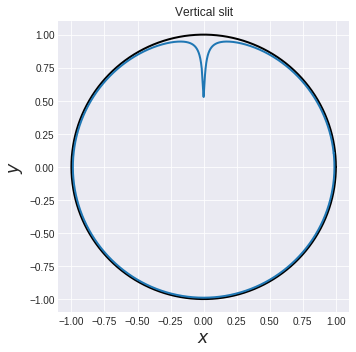

In [0]:
t = np.linspace(0, 2*np.pi, 10000)
circle_x = np.cos(t)
circle_y = np.sin(t)

cx = np.linspace(0, 2*np.pi, 10000)
cy = np.linspace(0, 2*np.pi, 10000)
for j in range(0,10000):
   z = radial_vslit_zip(0.99*np.cos(t[j])+0.99*1j*np.sin(t[j]), 0.1, 1j)
   cx[j] = z.real
   cy[j] = z.imag

end_time = 10
t = np.linspace(0.0001, end_time, 10000)


U = 4*np.sqrt(t) # driving function

u=np.zeros([1, len(t)], dtype=np.complex128)
u[0,:]=U

plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(5,5))

ax.set_title('Vertical slit')
plt.plot(circle_x, circle_y, lw=2, color="black")
plt.plot(cx, cy, lw=2)
#circle = plt.Circle((0, 0), 1, color='b', fill=False)
#ax.add_artist(circle)
ax.set_xlabel('$x$', fontsize='xx-large')
ax.set_ylabel('$y$', fontsize='xx-large')
ax.set_aspect('equal')

fig.tight_layout()
plt.show()


# Example 1: One slit

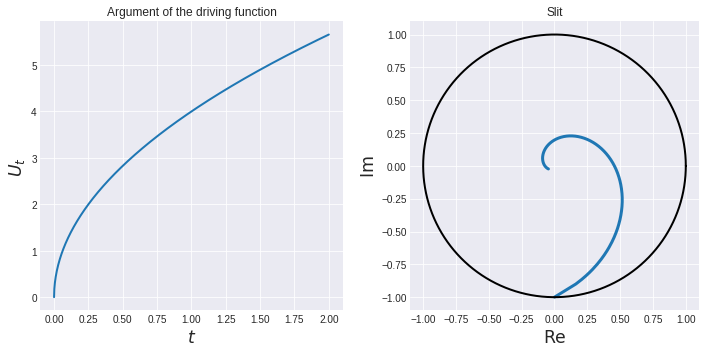

In [0]:
# Parameters
#======================
end_time = 2
t = np.linspace(0, end_time, 1000)
U_real = 4*np.sqrt(t)
#U_real = np.arcsinh(np.exp(-t)*np.sinh(1/2))-1/2
U = -1j*np.exp(1j*U_real) # driving function
#======================

# unit circle
t_circle = np.linspace(0, 2*np.pi, 10000)
circle_x = np.cos(t_circle)
circle_y = np.sin(t_circle)

u=np.zeros([1, len(t)], dtype=np.complex128)
u=u+1j
u[0,:]=U

# compute the trace in the upper half-plane
result = radial_multiple_slits(t, [1], u)  # returns a complex ndarray


plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

axs[0].set_title('Argument of the driving function')
axs[0].plot(t, U_real, lw=2)

axs[1].set_title('Slit')
axs[1].plot(result[0,].real, result[0,].imag, lw=3)
plt.plot(circle_x, circle_y, lw=2, color="black")

axs[0].set_xlabel('$t$', fontsize='xx-large')
axs[0].set_ylabel('$U_t$', fontsize='xx-large')
axs[1].set_aspect('equal')
axs[1].set_xlabel('$\mathsf{Re}$', fontsize='xx-large')
axs[1].set_ylabel('$\mathsf{Im}$', fontsize='xx-large')
fig.tight_layout()
plt.show()


#Example 2: oscillating driving function

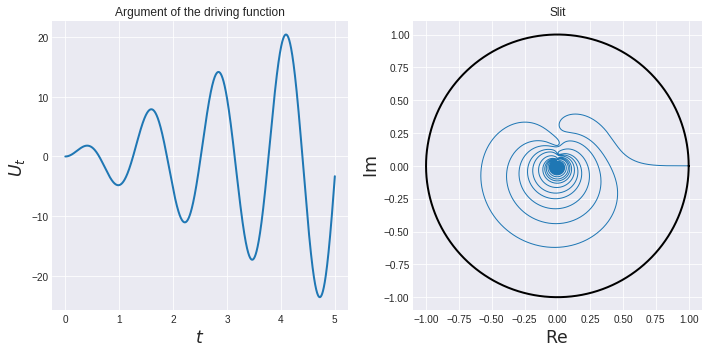

In [0]:
# Parameters
#======================
end_time = 5
t = np.linspace(0, end_time, 10000)
U_real = 5*t*np.sin(5*t) #0.7*np.sin( np.pi*0.01/(end_time+0.002-t) )
U = np.exp(1j*(U_real-U_real[0])) # driving function

#======================

# unit circle
t_circle = np.linspace(0, 2*np.pi, 10000)
circle_x = np.cos(t_circle)
circle_y = np.sin(t_circle)


u=np.zeros([1, len(t)], dtype=np.complex128)
u[0,:]=U

# compute the trace in the upper half-plane
result = radial_multiple_slits(t, [1], u)  # returns a complex ndarray

plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

axs[0].set_title('Argument of the driving function')
axs[0].plot(t, U_real, lw=2)

axs[1].set_title('Slit')
axs[1].plot(result[0,].real, result[0,].imag, lw=1)
axs[1].plot(circle_x, circle_y, lw=2, color="black")

axs[0].set_xlabel('$t$', fontsize='xx-large')
axs[0].set_ylabel('$U_t$', fontsize='xx-large')
axs[1].set_aspect('equal')
axs[1].set_xlabel('$\mathsf{Re}$', fontsize='xx-large')
axs[1].set_ylabel('$\mathsf{Im}$', fontsize='xx-large')
fig.tight_layout()
plt.show()

number_images = 100
file_path = 'radial_curve_evolution.gif'
#create_gif_file(result, number_images, file_path, True) 
#with open(file_path,'rb') as f:
 #   display(Image(data=f.read(), format='png', width=300, height=300)) #  width=160, height=210

In [0]:
create_gif_file(result, number_images, file_path, True) 
with open(file_path,'rb') as f:
   display(Image(data=f.read(), format='png', width=400, height=400)) #  width=160, height=210

# Example 3: One slit SLE

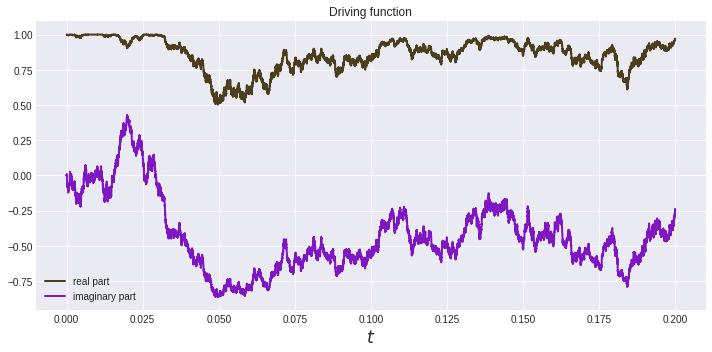

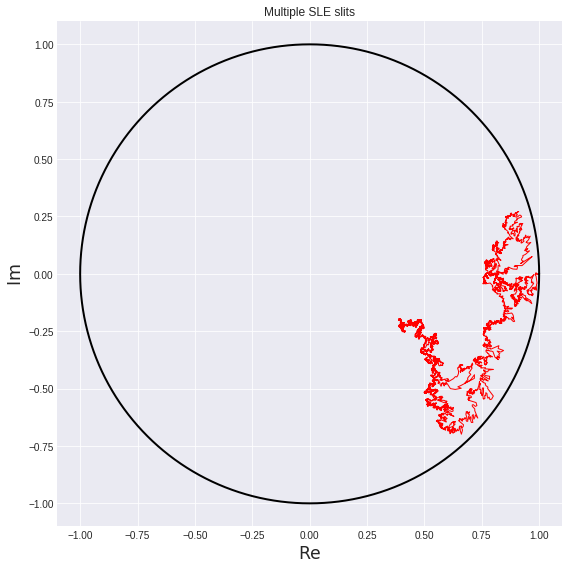

In [0]:
# Parameters
#======================
Nslits = 1
end_time = 0.2
x0 = np.linspace(0, np.pi, Nslits)
x0 = np.exp(1j * x0)
tspan = np.linspace(0.0, end_time, 20000)
lambdas = np.zeros(Nslits, dtype=np.float_) + 1/Nslits
kappa = 6 # the kappa from SLE(kappa)
#======================

#==============================================================================
# sum=0
# for k in range(0, Nslits, 1): 
#     lambdas[k] = 1/(k+1)
#     sum = sum + lambdas[k]
# for k in range(0, Nslits, 1): 
#     lambdas[k] = lambdas[k] / sum
#==============================================================================

# unit circle
t_circle = np.linspace(0, 2*np.pi, 10000)
circle_x = np.cos(t_circle)
circle_y = np.sin(t_circle)

u = radial_multiple_sle_driving_functions(kappa, Nslits, x0, tspan, lambdas)

z = radial_multiple_slits(tspan, lambdas, u)  # returns a complex ndarray

fig, axs = plt.subplots(figsize=(10, 5))
axs.set_title('Driving function')

axs.plot(tspan, u[0,:].real, lw=2,  color=np.random.rand(3,1)[:,0], label = "real part")
axs.plot(tspan, u[0,:].imag, lw=2,  color=np.random.rand(3,1)[:,0], label = "imaginary part")
#axs.set_aspect('equal')
axs.legend()
axs.set_xlabel('$t$', fontsize='xx-large')
fig.tight_layout()

fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title('Multiple SLE slits')
axs.plot(z[0,:].real, z[0,:].imag, lw=1, color=[1,0,0])
axs.set_aspect('equal')
axs.plot(circle_x, circle_y, lw=2, color="black")
axs.set_xlabel('$\mathsf{Re}$', fontsize='xx-large')
axs.set_ylabel('$\mathsf{Im}$', fontsize='xx-large')
#plt.ylim(0, 1)
#plt.xlim(-10, 10)
fig.tight_layout()

plt.show()

# Example 4: two slits

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


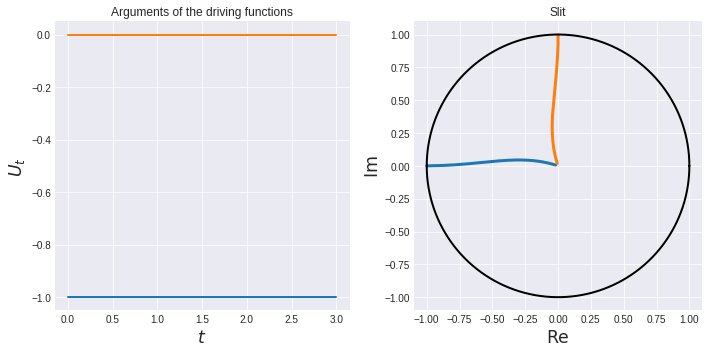

In [0]:
# Parameters
#======================
number_of_slits = 2
end_time = 3
t = np.linspace(0.0, end_time, 1000)
u1 = np.zeros(len(t)) - 1  # driving function constant -1
u2 = np.zeros(len(t)) + 1j  # driving function constant +1j
weights = [1/2, 1/2]
#======================

# unit circle
t_circle = np.linspace(0, 2*np.pi, 10000)
circle_x = np.cos(t_circle)
circle_y = np.sin(t_circle)

u = np.zeros([number_of_slits, len(t)], dtype=np.complex128)
u[0,:] = u1
u[1,:] = u2

# compute the trace in the upper half-plane
result = radial_multiple_slits(t, weights, u)  # returns a complex ndarray
z1 = result[0,]
z2 = result[1,]
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

axs[0].set_title('Arguments of the driving functions')
axs[0].plot(t, u1, lw=2)
axs[0].plot(t, u2, lw=2)

axs[1].set_title('Slit')
axs[1].plot(z1.real, z1.imag, lw=3)
axs[1].plot(z2.real, z2.imag, lw=3)
axs[1].plot(circle_x, circle_y, lw=2, color = "black")

axs[0].set_xlabel('$t$', fontsize='xx-large')
axs[0].set_ylabel('$U_t$', fontsize='xx-large')
axs[1].set_aspect('equal')
axs[1].set_xlabel('$\mathsf{Re}$', fontsize='xx-large')
axs[1].set_ylabel('$\mathsf{Im}$', fontsize='xx-large')
fig.tight_layout()
plt.show()


# Example 5: Multiple SLE

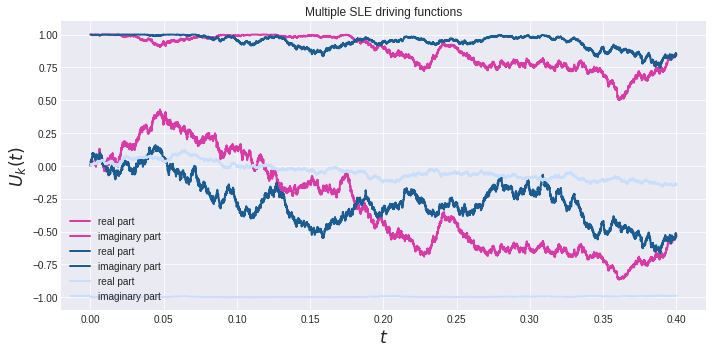

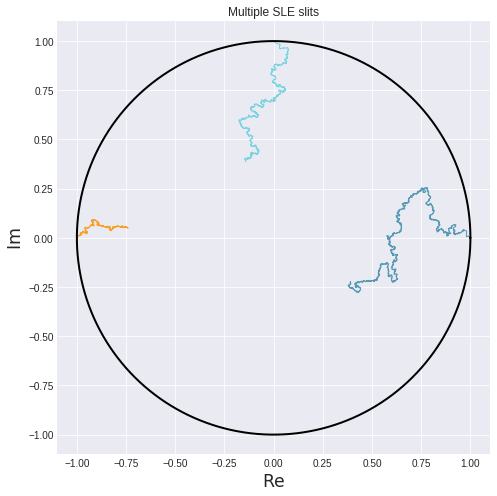

In [0]:
# Parameters
#======================
Nslits = 3
end_time = 0.4
x0 = np.linspace(0, np.pi, Nslits)
x0 = np.exp(1j * x0)
tspan = np.linspace(0.0, end_time, 10000)
lambdas = lambdas = [0.48, 0.48, 0.04]
kappa = 2 # the kappa from SLE(kappa)
#======================

#==============================================================================
# sum=0
# for k in range(0, Nslits, 1): 
#     lambdas[k] = 1/(k+1)
#     sum = sum + lambdas[k]
# for k in range(0, Nslits, 1): 
#     lambdas[k] = lambdas[k] / sum
#==============================================================================

# unit circle
t_circle = np.linspace(0, 2*np.pi, 10000)
circle_x = np.cos(t_circle)
circle_y = np.sin(t_circle)

u = radial_multiple_sle_driving_functions(kappa, Nslits, x0, tspan, lambdas)

z = radial_multiple_slits(tspan, lambdas, u)  # returns a complex ndarray

fig, axs = plt.subplots(figsize=(10, 5))
axs.set_title('Multiple SLE driving functions')

for k in range(0, Nslits, 1): 
    color = np.random.rand(3,1)[:,0]
    axs.plot(tspan, u[k,:].real, lw=2,  color=color, label = "real part")  #different red colors: color=[k/Nslits,0,0]
    axs.plot(tspan, u[k,:].imag, lw=2,  color=color, label = "imaginary part")
#axs.set_aspect('equal')
axs.legend()
axs.set_xlabel('$t$', fontsize='xx-large')
axs.set_ylabel('$U_k(t)$', fontsize='xx-large')
fig.tight_layout()

fig, axs = plt.subplots(figsize=(7, 7))
axs.set_title('Multiple SLE slits')
for k in range(0, Nslits, 1): 
    axs.plot(z[k,:].real, z[k,:].imag, lw=1,  color=np.random.rand(3,1)[:,0])
axs.set_aspect('equal')
axs.plot(circle_x, circle_y, lw=2, color="black")
axs.set_xlabel('$\mathsf{Re}$', fontsize='xx-large')
axs.set_ylabel('$\mathsf{Im}$', fontsize='xx-large')
#plt.ylim(0, 1)
#plt.xlim(-10, 10)
fig.tight_layout()

plt.show()



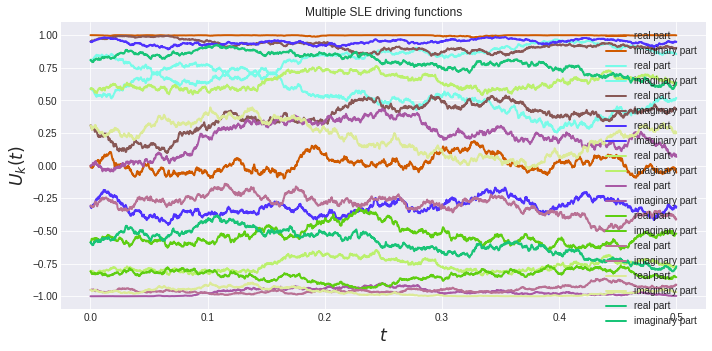

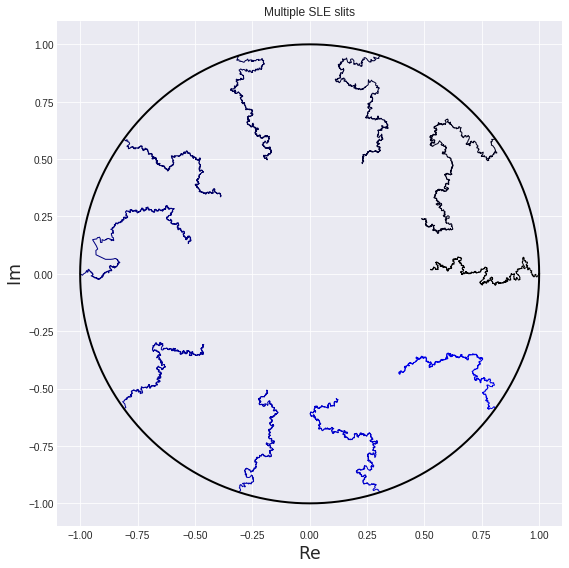

In [0]:
# Parameters
#======================
Nslits = 10
end_time = 0.5
x0 = np.linspace(0, 2*np.pi, Nslits+1)
x0 = x0[0:Nslits]
x0 = np.exp(1j * x0)
tspan = np.linspace(0.0, end_time, 2000)
lambdas = np.zeros(Nslits, dtype=np.float_) + 1/Nslits
kappa = 2 # the kappa from SLE(kappa)
#======================

#==============================================================================
# sum=0
# for k in range(0, Nslits, 1): 
#     lambdas[k] = 1/(k+1)
#     sum = sum + lambdas[k]
# for k in range(0, Nslits, 1): 
#     lambdas[k] = lambdas[k] / sum
#==============================================================================

# unit circle
t_circle = np.linspace(0, 2*np.pi, 10000)
circle_x = np.cos(t_circle)
circle_y = np.sin(t_circle)

u = radial_multiple_sle_driving_functions(kappa, Nslits, x0, tspan, lambdas)

z = radial_multiple_slits(tspan, lambdas, u)  # returns a complex ndarray

fig, axs = plt.subplots(figsize=(10, 5))
axs.set_title('Multiple SLE driving functions')

for k in range(0, Nslits, 1): 
    color = np.random.rand(3,1)[:,0]
    axs.plot(tspan, u[k,:].real, lw=2,  color=color, label = "real part")  #different red colors: color=[k/Nslits,0,0]
    axs.plot(tspan, u[k,:].imag, lw=2,  color=color, label = "imaginary part")
#axs.set_aspect('equal')
axs.legend()
axs.set_xlabel('$t$', fontsize='xx-large')
axs.set_ylabel('$U_k(t)$', fontsize='xx-large')
fig.tight_layout()

fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title('Multiple SLE slits')
for k in range(0, Nslits, 1): 
   # axs.plot(z[k,:].real, z[k,:].imag, lw=1,  color=np.random.rand(3,1)[:,0])
   axs.plot(z[k,:].real, z[k,:].imag, lw=1,  color= [0,0,k/Nslits])
axs.set_aspect('equal')
axs.plot(circle_x, circle_y, lw=2, color="black")
axs.set_xlabel('$\mathsf{Re}$', fontsize='xx-large')
axs.set_ylabel('$\mathsf{Im}$', fontsize='xx-large')
#plt.ylim(0, 1)
#plt.xlim(-10, 10)
fig.tight_layout()

plt.show()




# Example 6: Plot the hull from the Burgers equation with initial measure = Dirac measure at 1.

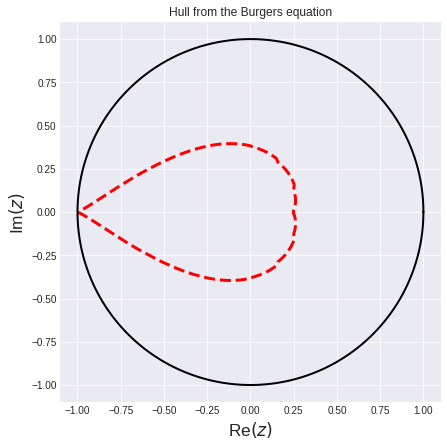

In [0]:
# unit circle
t_circle = np.linspace(0, 2*np.pi, 10000)
circle_x = np.cos(t_circle)
circle_y = np.sin(t_circle)

end_time = 1

plt.style.use('seaborn-darkgrid')

result_burgers = radial_burgers(np.linspace(0, end_time, 1000), 1000)


col=np.random.rand(3,1) # we use a random color for plotting
plt.figure(figsize=(7,7))
plt.plot(result_burgers.real, result_burgers.imag, lw=3, linestyle='dashed', color=[1,0,0])
plt.plot(circle_x, circle_y, lw=2, color="black")
ax = plt.gca()
ax.set_aspect('equal')
ax.set_title('Hull from the Burgers equation')
ax.set_xlabel('Re$(z)$', fontsize='xx-large')
ax.set_ylabel('Im$(z)$', fontsize='xx-large')
#ax.fill_between(result.real, result.imag, color=col[:,0])
ax.set_alpha(0.0)

plt.show()

Plot the Burgers hull and multiple SLE slits with equal weights, which approximate the hull:

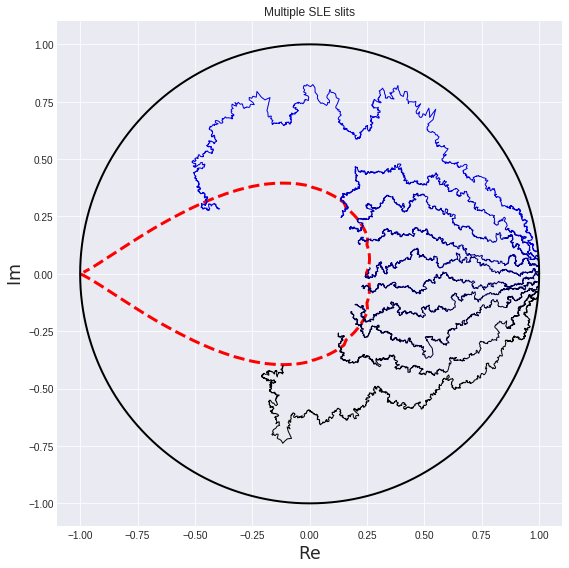

In [0]:
# Parameters
#======================
Nslits = 10
end_time = 1
x0 = np.linspace(-1/Nslits, 1/Nslits, Nslits)
x0 = np.exp(1j * x0)
tspan1 = np.linspace(0.0, 0.02, 2000) # first time interval, dense spacing
tspan2 = np.linspace(0.02, end_time, 1000) # second time interval, coarse spacing
tspan = np.concatenate((tspan1, tspan2), axis = None)
lambdas = np.zeros(Nslits, dtype=np.float_) + 1/Nslits
kappa = 2 # the kappa from SLE(kappa)
#======================

#==============================================================================
# sum=0
# for k in range(0, Nslits, 1): 
#     lambdas[k] = 1/(k+1)
#     sum = sum + lambdas[k]
# for k in range(0, Nslits, 1): 
#     lambdas[k] = lambdas[k] / sum
#==============================================================================

# unit circle
t_circle = np.linspace(0, 2*np.pi, 10000)
circle_x = np.cos(t_circle)
circle_y = np.sin(t_circle)


u = np.zeros([Nslits, len(tspan)], dtype=np.complex128)
u1, u2 = radial_multiple_sle_driving_functions2(kappa, Nslits, x0, tspan1, tspan2, lambdas)
for k in range(Nslits):
  u[k,:] = np.concatenate((u1[k,:], u2[k,:]),axis=None)

z = radial_multiple_slits(tspan, lambdas, u)  # returns a complex ndarray

#result_burgers = radial_burgers(np.linspace(0, end_time, 10000), 100)

fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title('Multiple SLE slits')

axs.plot(result_burgers.real, result_burgers.imag, lw=3, linestyle='dashed', color=[1,0,0])

for k in range(0, Nslits, 1): 
    axs.plot(z[k,:].real, z[k,:].imag, lw=1, color = [0,0,k/Nslits])
axs.set_aspect('equal')
axs.plot(circle_x, circle_y, lw=2, color="black")
axs.set_xlabel('$\mathsf{Re}$', fontsize='xx-large')
axs.set_ylabel('$\mathsf{Im}$', fontsize='xx-large')
#plt.ylim(0, 1)
#plt.xlim(-10, 10)
fig.tight_layout()
ax.set_alpha(0.0)
plt.show()

In [0]:
number_images = 100
file_path = 'radial_curve_evolution.gif'
create_gif_file(z, number_images, file_path, True) 
with open(file_path,'rb') as f:
    display(Image(data=f.read(), format='png', width=300, height=300)) #  width=160, height=210

# Saving the file:
#from google.colab import drive
#drive.mount('/content/drive')
#!cp 'radial_curve_evolution.gif' '/content/drive/My Drive/radial_curve_evolution.gif'	   

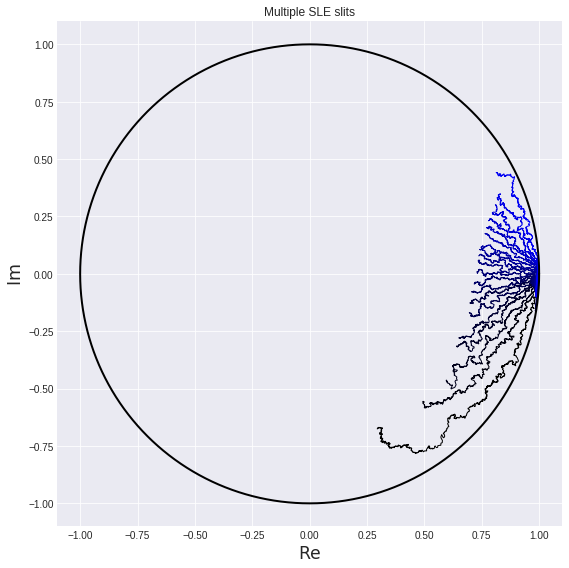

In [0]:
# Parameters
#======================
Nslits = 20
end_time = 0.1
x0 = np.linspace(-1/Nslits, 1/Nslits, Nslits)
x0 = np.exp(1j * x0)
tspan1 = np.linspace(0.0, 0.02, 2000) # first time interval, dense spacing
tspan2 = np.linspace(0.02, end_time, 1000) # second time interval, coarse spacing
tspan = np.concatenate((tspan1, tspan2), axis = None)
lambdas = np.zeros(Nslits, dtype=np.float_) + 1/Nslits
kappa = 2 # the kappa from SLE(kappa)
#======================

#==============================================================================
sum=0
for k in range(0, Nslits, 1): 
    lambdas[k] = 1/(k+1)
    sum = sum + lambdas[k]
for k in range(0, Nslits, 1): 
    lambdas[k] = lambdas[k] / sum
#==============================================================================

# unit circle
t_circle = np.linspace(0, 2*np.pi, 10000)
circle_x = np.cos(t_circle)
circle_y = np.sin(t_circle)


u = np.zeros([Nslits, len(tspan)], dtype=np.complex128)
u1, u2 = radial_multiple_sle_driving_functions2(kappa, Nslits, x0, tspan1, tspan2, lambdas)
for k in range(Nslits):
  u[k,:] = np.concatenate((u1[k,:], u2[k,:]),axis=None)

z = radial_multiple_slits(tspan, lambdas, u)  # returns a complex ndarray

#result_burgers = radial_burgers(np.linspace(0, end_time, 10000), 100)

fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title('Multiple SLE slits')

#axs.plot(result_burgers.real, result_burgers.imag, lw=3, linestyle='dashed', color=[1,0,0])

for k in range(0, Nslits, 1): 
    axs.plot(z[k,:].real, z[k,:].imag, lw=1, color = [0,0,k/Nslits])
axs.set_aspect('equal')
axs.plot(circle_x, circle_y, lw=2, color="black")
axs.set_xlabel('$\mathsf{Re}$', fontsize='xx-large')
axs.set_ylabel('$\mathsf{Im}$', fontsize='xx-large')
#plt.ylim(0, 1)
#plt.xlim(-10, 10)
fig.tight_layout()
ax.set_alpha(0.0)
plt.show()
